In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Rescaling, Cropping2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Data Sources

In [2]:
train_loc = '/kaggle/input/histopathologic-cancer-detection/train/'
test_loc = '/kaggle/input/histopathologic-cancer-detection/test/'
train_labels_file = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

# Description of Data/Problem

**Problem**
The challenge is a binary image classification task. Given a 96x96 pixel RGB image patch extracted from a larger slide, we need to predict whether the central 32x32 pixel area contains any tumor tissue. This is crucial for automating the detection of metastatic cancer, potentially speeding up diagnosis and reducing pathologist workload.

**Data**
* **Training Data:** Consists of 220,025 labeled image patches (`.tif` files) located in the `train/` directory. Each image is 96x96 pixels in RGB format. The labels are provided in `train_labels.csv`.
* **Label File (`train_labels.csv`):** Contains two columns:
    * `id`: A unique string identifier for each image file (without the `.tif` extension).
    * `label`: An integer indicating the class (0 for no tumor, 1 for tumor).
* **Test Data:** Consists of 57,458 unlabeled image patches in the `test/` directory, structurally identical to the training images. We need to predict labels for these images.
* **Image Properties:**:
     * Size: 96x96 pixels
     * Format: TIFF
     * Mode: RGB (3 color channels)

In [3]:
df_train_labels = pd.read_csv(train_labels_file)
print("Training Label Info:")
df_train_labels.info()

Training Label Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
print("First few rows:")
df_train_labels.head()

First few rows:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Metadata from an image confirming the Kaggle listed data size and format

In [5]:
sample_img = df_train_labels.iloc[0]['id']
sample_img_path = train_loc + sample_img + '.tif'
print(sample_img_path)
img = Image.open(sample_img_path)
img_info = {
    'File': img.filename,
    'Image Size': img.size,
    'Image Format': img.format,
    'Image Mode': img.mode
}
print(img_info)
img.close()

/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif
{'File': '/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif', 'Image Size': (96, 96), 'Image Format': 'TIFF', 'Image Mode': 'RGB'}


# Exploratory Data Analysis (EDA)

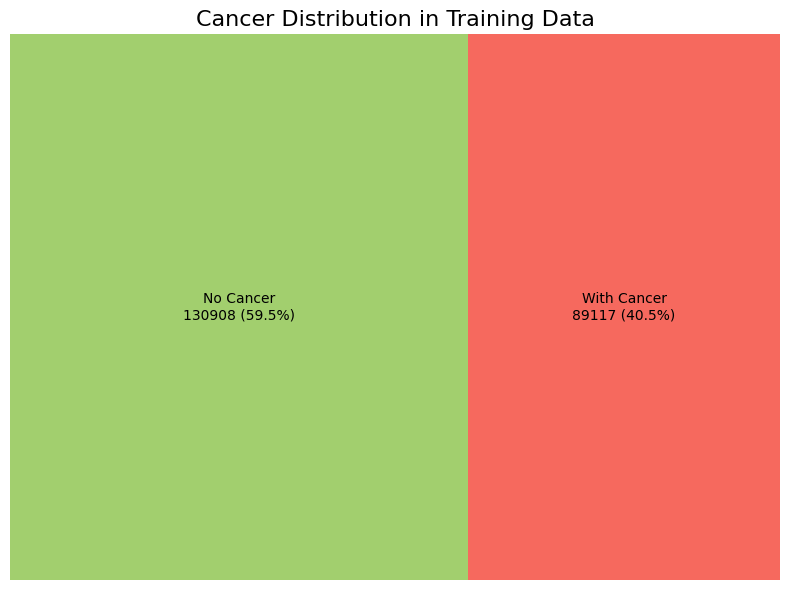

In [6]:
counts = df_train_labels['label'].value_counts().sort_index()
total = counts.sum()
percentages = counts / total * 100

labels = ['No Cancer', 'With Cancer']
colors = ['#8BC34A', '#F44336']

labels_with_info = [f"{label}\n{count} ({percentage:.1f}%)" 
                    for label, count, percentage in zip(labels, counts.values, percentages.values)]

plt.figure(figsize=(8, 6))
squarify.plot(sizes=counts.values, label=labels_with_info, color=colors, alpha=.8)
plt.title("Cancer Distribution in Training Data", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

**Observation:** The dataset contains 130,908 images labeled '0' (no cancer) and 89,117 images labeled '1' (with cancer). This represents approximately 59.5% negative class and 40.5% positive class. While not perfectly balanced, the imbalance isn't extreme. However, it's significant enough that we should consider it during model training and evaluation.

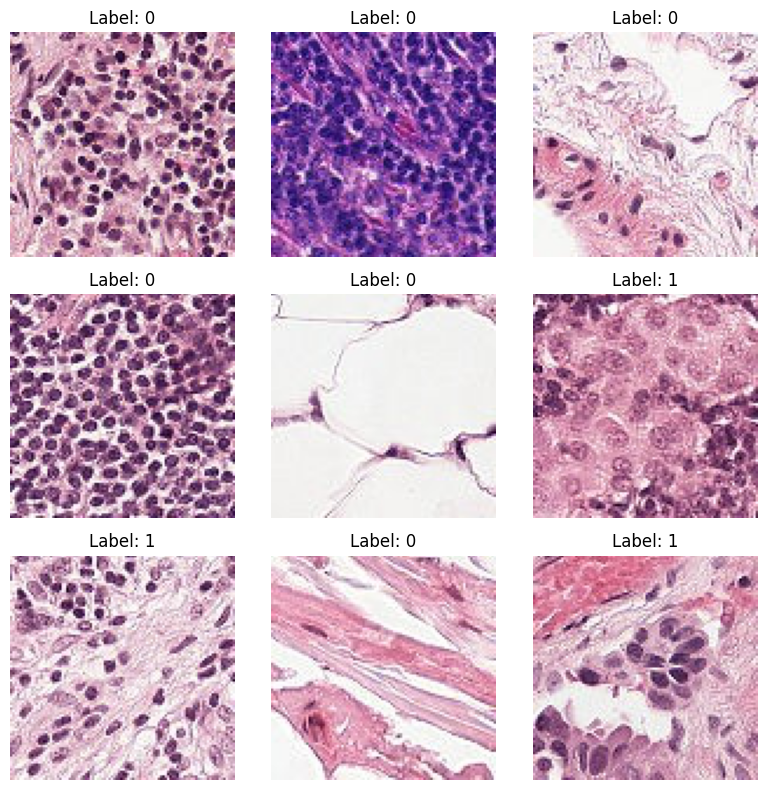

In [7]:
sample_ids = df_train_labels['id'].sample(9, random_state=10).values
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()
for ax, image_id in zip(axes, sample_ids):
    image_path = os.path.join(train_loc, image_id + '.tif')
    img = Image.open(image_path)
    label = df_train_labels[df_train_labels['id'] == image_id]['label'].values[0]
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

**Observation** As an untrained individual, it is hard to immediately see differences between the cancerous and non-cancerous slides.

# Preprocessing

In [8]:
# Create a copy of our initial csv dataframe and modify it to ensure we have correct data types
df_train_working = df_train_labels.copy()
df_train_working['label'] = df_train_working['label'].astype(str)
df_train_working['id'] = df_train_working['id'].astype(str) + '.tif'
print("Updated DataFrame:")
df_train_working.head()

Updated DataFrame:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [9]:
# Here I use stratify to ensure similar class distribution in both sets
n = 30000 # n controls how much of the data is used for training run because the full data set is quite large. Used 30k for competition submissions but lowered for programming runs
train_df, val_df = train_test_split(
    df_train_working[:n],
    test_size=0.2,  # Using 20% for validation
    random_state=10,
    stratify=df_train_working['label'][:n]
)

In [10]:
print(f"\nTraining set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")

# Verify stratification
print("\nTraining set label distribution:")
print(train_df['label'].value_counts(normalize=True))
print("\nValidation set label distribution:")
print(val_df['label'].value_counts(normalize=True))


Training set shape: (24000, 2)
Validation set shape: (6000, 2)

Training set label distribution:
label
0    0.59775
1    0.40225
Name: proportion, dtype: float64

Validation set label distribution:
label
0    0.597833
1    0.402167
Name: proportion, dtype: float64


In [11]:
train_df['filepath'] = train_df['id'].apply(lambda x: os.path.join(train_loc, x))
val_df['filepath'] = val_df['id'].apply(lambda x: os.path.join(train_loc, x))

train_df['label_int'] = train_df['label'].astype(int)
val_df['label_int'] = val_df['label'].astype(int)

train_filepaths = train_df['filepath'].values
train_labels = train_df['label_int'].values

val_filepaths = val_df['filepath'].values
val_labels = val_df['label_int'].values

print(f"Prepared {len(train_filepaths)} train filepaths and {len(val_filepaths)} validation filepaths.")
print("Sample train filepath:", train_filepaths[0])
print("Sample train label:", train_labels[0])

Prepared 24000 train filepaths and 6000 validation filepaths.
Sample train filepath: /kaggle/input/histopathologic-cancer-detection/train/e066d60871e8dcf38fa636d073fb8dfb4f66575d.tif
Sample train label: 0


In [12]:
def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    
X = np.array([load_image(path) for path in train_df['filepath']])
y = train_df['label_int'].values

x_val = np.array([load_image(path) for path in val_df['filepath']])
y_val = val_df['label_int'].values

# Model Architecture

For my model architecture I will use two different sized models and compare their performance. The first will be a traditional simple sequential Convolutional Neural Network (CNN). CNNs are well-suited for image data because they use convolutional layers to automatically learn hierarchical spatial features (edges, textures, shapes) directly from the pixel data. Pooling layers also provide some translation invariance and reduce dimensionality. I will then compare this approach to 

In [13]:
def build_small_cnn(input_shape=(96, 96, 3)):
    """Builds a very basic sequential CNN."""
    model = Sequential([
        Input(shape=input_shape),
        Rescaling(1./255),
        Cropping2D(cropping=32),

        # Block 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    return model

**Simple CNN Overview**

Architecture: Consists of two convolutional blocks with one convolution and one pooling layer each, followed by flattening and two dense layers. Uses less filters than the following large model.

In [14]:
cnn_small_model = build_small_cnn()
cnn_small_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          32,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,889 (148.00 KB)

 Trainable params: 37,889 (148.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def build_large_cnn(input_shape=(96, 96, 3)):
    """Builds a larger CNN model."""
    model = Sequential([
        Input(shape=input_shape),
        Rescaling(1./255),
        Cropping2D(cropping=32),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Flatten and Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # using sigmoid activation for binary classification
    ])

    return model

**Large Model Overview**
* Starts with convolutional blocks (Conv2D layers with ReLU activation and same padding) to extract features.
 * MaxPooling2D layers are used after each block to downsample the feature maps, reducing computation.
 * Dropout layers are added after pooling layers and before the final dense layer to mitigate overfitting by randomly setting a fraction of input units to 0 during training.
 * The feature maps are Flattened into a 1D vector.
 * A Dense layer (64 units with ReLU) acts as a classifier head.
 * The final Dense layer has a single neuron with a sigmoid activation function to output a probability between 0 and 1.

In [16]:
cnn_large_model = build_large_cnn()
cnn_large_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,209 (1.60 MB)

 Trainable params: 418,209 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

Hyperparameter Choices (Initial)
* **Optimizer:** Adam is a common and effective choice
* **Learning Rate:** `1e-3` for Adam
* **Loss Function:** `binary_crossentropy` is standard for binary classification problems with sigmoid output.
* **Metrics:** `AUC` (Area Under ROC Curve) is the primary competition metric and good for imbalanced data.

Based on defaults: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [17]:
# Stop training if validation AUC doesn't improve for 'patience' epochs
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=15,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


callbacks_list = [early_stopping]

def compile_model(model, learning_rate=1e-3):
    """Compiles the model with Adam optimizer and metrics."""
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.AUC(name='auc'), # Primary metric
            'accuracy'                        # Secondary metric
        ]
    )
    return model

In [18]:
NUM_EPOCHS = 50

In [19]:
# Train Small Model

cnn_small_model = build_small_cnn()
cnn_small_compiled = compile_model(cnn_small_model,learning_rate = 1e-3)
history_small_cnn = cnn_small_compiled.fit(
    X,
    y,
    epochs=NUM_EPOCHS,
    validation_data=[x_val,y_val],
    callbacks=callbacks_list,
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.6541 - auc: 0.6924 - loss: 0.6217 - val_accuracy: 0.7685 - val_auc: 0.8264 - val_loss: 0.5229
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7383 - auc: 0.7872 - loss: 0.5528 - val_accuracy: 0.7755 - val_auc: 0.8419 - val_loss: 0.4935
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7443 - auc: 0.7971 - loss: 0.5411 - val_accuracy: 0.7852 - val_auc: 0.8452 - val_loss: 0.5026
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7610 - auc: 0.8145 - loss: 0.5234 - val_accuracy: 0.7553 - val_auc: 0.8400 - val_loss: 0.5180
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7626 - auc: 0.8162 - loss: 0.5183 - val_accuracy: 0.7890 - val_auc: 0.8524 - val_loss: 0.4803
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7738 - auc: 0.8291 - loss: 0.5055 - val_accuracy: 0.7862 - val_auc: 0.8534 - val_loss: 0.4762
Epoch 7/50
750/750 ━━━━━━━━━

In [20]:
#Skipped unless preparing a submission to the competition

# test_paths = os.listdir(test_loc)
# test_ids = [x.split('.')[0] for x in test_paths]
# test_paths = [test_loc + i for i in test_paths]
# test_X = np.array([load_image(path) for path in test_paths])

In [21]:
#Skipped unless preparing a submission to the competition
# pred = cnn_small_compiled.predict(test_X)
# pred_reshape = pred.reshape(-1)

In [22]:
# submission_df = pd.DataFrame({
#     'id': test_ids,
#     'label': pred_reshape}
# )

In [23]:
# submission_df.head()

In [24]:
# submission_df.to_csv('submission_small.csv', index=False)

In [25]:
# Train Large Model

cnn_large_model = build_large_cnn()
cnn_large_compiled = compile_model(cnn_large_model,learning_rate = 1e-3)
history_large_cnn = cnn_large_compiled.fit(
    X,
    y,
    epochs=NUM_EPOCHS,
    validation_data=[x_val,y_val],
    callbacks=callbacks_list,
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 86s 112ms/step - accuracy: 0.6204 - auc: 0.6013 - loss: 0.6498 - val_accuracy: 0.7595 - val_auc: 0.8264 - val_loss: 0.5215
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.7492 - auc: 0.8031 - loss: 0.5299 - val_accuracy: 0.7762 - val_auc: 0.8383 - val_loss: 0.4966
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.7684 - auc: 0.8249 - loss: 0.5048 - val_accuracy: 0.7757 - val_auc: 0.8532 - val_loss: 0.4846
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.7766 - auc: 0.8332 - loss: 0.4919 - val_accuracy: 0.7850 - val_auc: 0.8446 - val_loss: 0.4780
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 110ms/step - accuracy: 0.7805 - auc: 0.8412 - loss: 0.4832 - val_accuracy: 0.7870 - val_auc: 0.8613 - val_loss: 0.4699
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - accuracy: 0.7926 - auc: 0.8552 - loss: 0.4664 - val_accuracy: 0.7730 - val_auc: 0.8682 - val_loss: 0.4827
Epoch 7/50
750/750 ━━

In [26]:
#Skipped unless preparing a submission to the competition

# pred = cnn_large_compiled.predict(test_X)
# pred_reshape = pred.reshape(-1)
# submission_df = pd.DataFrame({
#     'id': test_ids,
#     'label': pred_reshape}
# )

In [27]:
# submission_df.to_csv('submission_large.csv', index=False)

**Initial Results- Model Comparison**

| Model     | Private Score (From Kaggle) |
|-----------|-----------------------------|
| Small CNN | 0.8347                      |
| Large CNN | 0.8510                      |
Note these were results from n = 30,000 input

As we can see from the Kaggle private eval data the increase in model complexity resulted in a slight increase in test accuracy. This increase came at the cost of signifiacntly more training time compute. From the model epochs, we can see that difference was an order of magnitude difference meaning gains are likely to come from a either a different architecture or more accurate hyperparameters and not just expanding the convolutional blocks.

# Results Visualizations

In [28]:
def plot_history(model):
    history = model.history

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

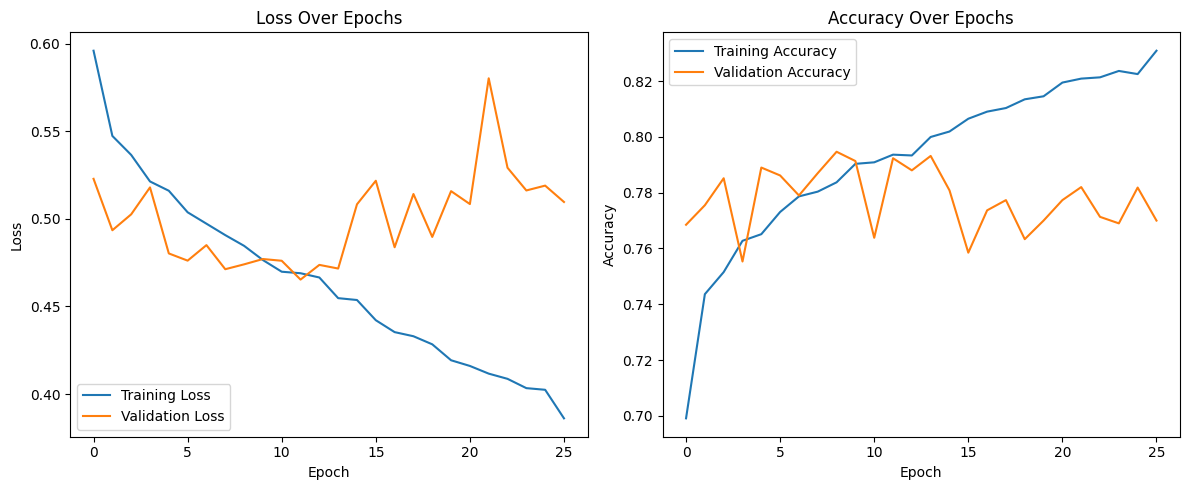

In [29]:
plot_history(history_small_cnn)

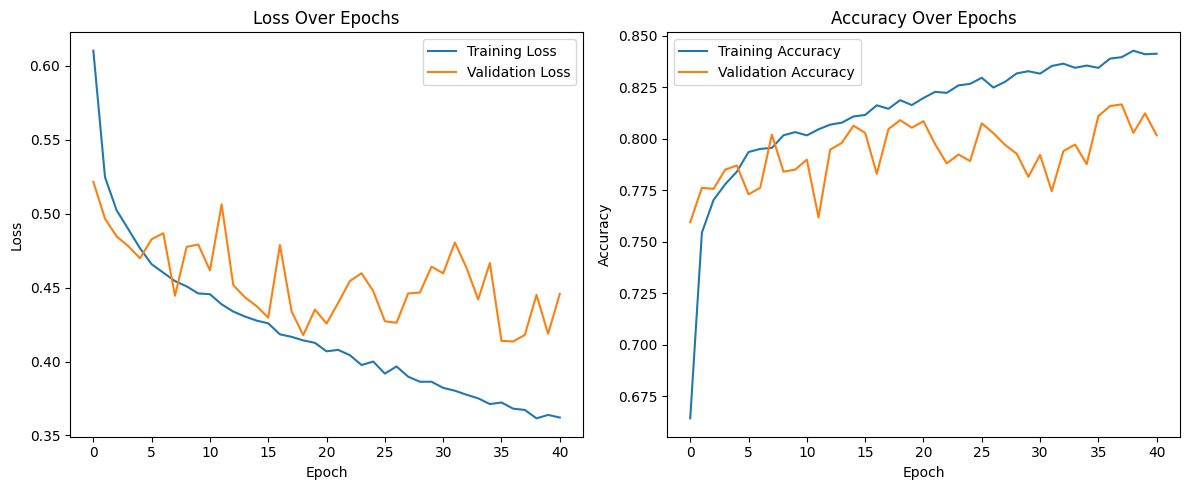

In [30]:
plot_history(history_large_cnn)

Training Performance: The training loss decreases consistently, and the training accuracy increases steadily, which shows that the model is learning well on the training data.

Validation Performance: The validation metrics are more erratic. The validation loss of both runs shows significant fluctuations, and the validation accuracy, while generally increasing, also varies more than the training accuracy. This suggests that the model may be overfitting to the training data.

Overfitting Indications: The training loss is consistently lower than the validation loss, and the training accuracy is consistently higher than the validation accuracy. This discrepancy suggests that the model is performing better on the training data than on unseen data, a classic sign of overfitting. 

Model Stability: The fluctuations in the validation loss and accuracy suggest that the model’s performance on unseen data is unstable. Similar to overfitting, some data augmentation techniques like flips and rotations could help here. This also shows room for better hyperparameter tuning.

# Hyperparameter- Learning Rate

In [31]:
# Rebuilding the small model with a faster learning rate
cnn_small_model_2 = build_small_cnn()
cnn_small_compiled_2 = compile_model(cnn_small_model_2,learning_rate = 2e-3)
history_small_cnn_2 = cnn_small_compiled_2.fit(
    X,
    y,
    epochs=NUM_EPOCHS,
    validation_data=[x_val,y_val],
    callbacks=callbacks_list,
)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6732 - auc: 0.7118 - loss: 0.6091 - val_accuracy: 0.7577 - val_auc: 0.8182 - val_loss: 0.5469
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7551 - auc: 0.8072 - loss: 0.5322 - val_accuracy: 0.7747 - val_auc: 0.8390 - val_loss: 0.4934
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.7571 - auc: 0.8122 - loss: 0.5240 - val_accuracy: 0.7825 - val_auc: 0.8461 - val_loss: 0.4824
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7642 - auc: 0.8223 - loss: 0.5134 - val_accuracy: 0.7830 - val_auc: 0.8440 - val_loss: 0.4846
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.7723 - auc: 0.8310 - loss: 0.5049 - val_accuracy: 0.7795 - val_auc: 0.8447 - val_loss: 0.4899
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7799 - auc: 0.8401 - loss: 0.4911 - val_accuracy: 0.7862 - val_auc: 0.8477 - val_loss: 0.4726
Epoch 7/50
750/750 ━━━━━━━━━

In [32]:
#Skipped unless preparing a submission to the competition

# pred = cnn_small_compiled_2.predict(test_X)
# pred_reshape = pred.reshape(-1)

In [33]:
# pred = cnn_large_compiled.predict(test_X)
# pred_reshape = pred.reshape(-1)
# submission_df = pd.DataFrame({
#     'id': test_ids,
#     'label': pred_reshape}
# )

In [34]:
# submission_df.to_csv('submission_high_learning.csv', index=False)

The higher learning rate resulted in the small model achieving an identical score (0.8510 for n = 30k) to the large model. This shows that effective hyperparmater tuning can result in noticeable gains to model performance by avoiding some local minimums.

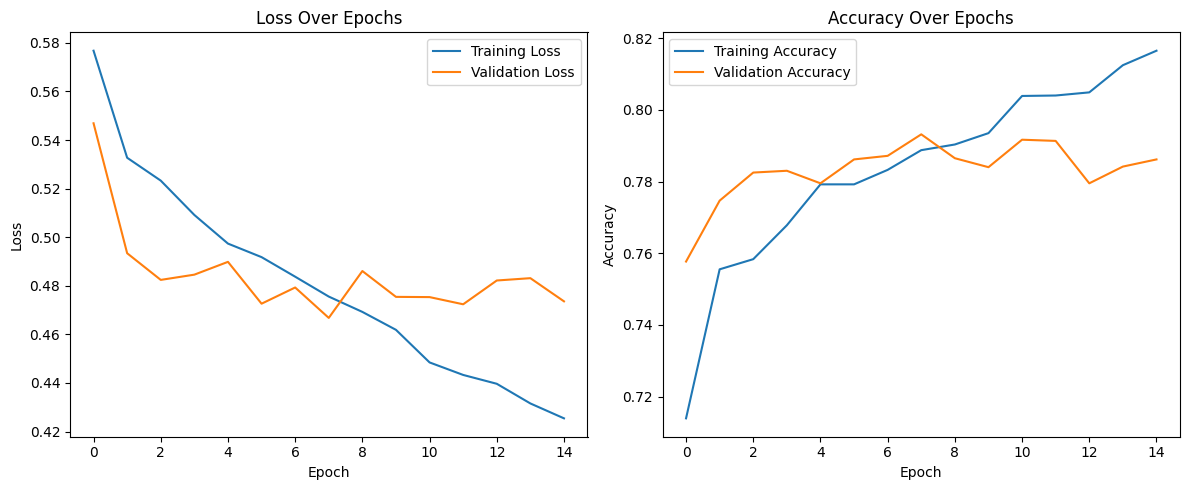

In [35]:
plot_history(history_small_cnn_2)

# Conclusion

The simple model performed quite well given its reduced complexity. For a field like medecine, the trade off is likely worth it to train a larger and more accurate model. However, in scenarios where rapid retraining on new data might be more appropriate, a simpler model might actually be a better choice. Additionally, even small changes in learning rate had a rather large impact on the training curve. This highlights the importance of hyperparameters on performance.

* In the future, there are a number of improvements that could be made to the model and training process:
    *  Include data augmentation techniques like rotations, flips, and shifts
    *  Add additional dropout layers and/or bigger convolution blocks
    *  Use a different optimizer or experiment with Adam default parameters
    *  Add different optimization techniques like momentum or custom learning rate variables

Sources:

https://keras.io/examples/vision/image_classification_from_scratch/

https://keras.io/api/optimizers/adam/